In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import glob
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

plt.ion()   # interactive mode
from skimage.transform import   rescale, resize 
from imageio import imread


In [2]:
configs = {

	"model": {
		"network": "squeezenet1_0",
		"device": "cuda",
		"checkpoint_path": "/pstore/home/shetabs1/runs/synapse_classification_test/2020-07-24 14:37:39.117541_squeezenet1_0_sgd_0.001/models/best_model.pth",
		"args": {}
	},
	"loss": {
		"loss_function": "CrossEntropyLoss", 
		"weights": None
	},
	"optimizer": {
		"optimization_method": "adam",
		"optimization_parameters": {
			"lr": 1e-3,
			"weight_decay": 0 
		}
	},
	"training": {
		"num_epochs": 100,
		"device": "cuda",
		"metrics_of_interest": ["accuracy", "f1_macro", "f1_weighted", "cross_entropy"],
		"call_back": {
			"patience": 90,
			"saving_period": 100,
			"criteria": "f1_macro"
		},
		"verbosity": 1,
		"lr_scheduler": {
			"type": "StepLR",
			"args": {
				"step_size": 60,
				"gamma": 0.1
			}
		}

	},
	"data_loader": {
		"data_dir":  [ "/pstore/data/DS4/synapse_formation/Experiment_12_labeled_data_merged"],
		"batch_size": 10,
		"dynamic_range": {
				"lower_bound":0.01,
				"upper_bound":0.9999
		},
		"data_map": ["map_zero_one","normalize"],
		"validation_split": 0.25,
		"test_data_dir": [],
		"augmentation": [ "random_crop", "random_flip", "affine_transformation" , "random_gaussian_noise", "random_erasing"],
		"scaling_factor": 4095,
		"num_workers": 24

	},
	"tensorboard": {
		"tensorboard_path": "/pstore/home/shetabs1/runs/synapse",
		"add_metrics": True,
		"add_images": True,
		"add_confusion_matrix": True,
		"add_graph": False,
		"add_pr_curve": False,
		"add_hparams": False,
		"add_embedding": False
	}
}

In [11]:
from .utils import *
import logging

ModuleNotFoundError: No module named '__main__.utils'; '__main__' is not a package

In [4]:
    device = configs["training"]["device"]

    # seperating the configs part
    model_configs = configs["model"]
    loss_configs = configs["loss"]
    optimizer_configs = configs["optimizer"]
    training_configs = configs["training"]
    data_loader_configs = configs["data_loader"]
    tensorboard_configs = configs["tensorboard"]

In [5]:
    # check whether there is a model to continue for transfer learning
    checkpoint = get_checkpoint(model_configs["checkpoint_path"])

    # creating a unique name for the model
    run_name = create_name( model_configs["network"], 
                            optimizer_configs["optimization_method"] , 
                            optimizer_configs["optimization_parameters"]["lr"] )
                         
    # creating the tensorboard
    #writer = TensorBoardSummaryWriter(tensorboard_configs, run_name  )
    
    
    # creating the folder for the models to be saved per epoch
    #model_folder = os.path.join(writer.tensorboard_path, run_name, "models/")
    #make_folders(model_folder)

    

In [6]:
data_loader = DataLoaderGenerator(data_loader_configs) 

In [7]:
data_loader.data_frame_creator()

In [8]:
data_loader.existing_channels

['Ch1', 'Ch2', 'Ch3', 'Ch4', 'Ch6', 'Ch7']

In [9]:
    # number of exsting channels and output classes
    number_of_channels = len(data_loader.existing_channels)
    number_of_classes = len(data_loader.classes)

    # initialize the model
    model = get_model(  model_configs,
                        device,
                        checkpoint,
                        number_of_channels ,
                        number_of_classes)

In [10]:
data_loader.data_loader(model.image_size, checkpoint)

In [11]:
j = 500


In [50]:

x = data_loader.train_dataset.__getitem__(j)["image"].reshape(1,6,180,180)

In [51]:
data_loader.train_dataset.__getitem__(j)["label"]

tensor([0])

In [52]:
data_loader.classes

['Doublet_with_interaction',
 'Doublet_with_no_interaction',
 'Multiplet',
 'SingleBcell',
 'SingleTcell',
 'SingleTcell_Functional']

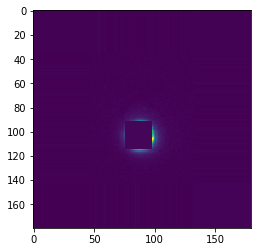

In [62]:
%matplotlib inline
plt.imshow(x.detach().cpu().numpy()[0,3,:,:])

In [63]:
model(x.reshape(1,6,180,180).float()).argmax()

tensor(3)

In [64]:
_, predicted = torch.max(model(x.reshape(1,6,180,180).float()), 1) 

In [65]:
from grad_cam.grad_cam import (
    BackPropagation,
    Deconvnet,
    GradCAM,
    GuidedBackPropagation,
    occlusion_sensitivity,
)

In [66]:
i = 0

In [67]:
bp = BackPropagation(model=model)

In [68]:
probs, ids = bp.forward(x.float())  # sorted

In [69]:
ids

tensor([[3, 0, 1, 5, 2, 4]])

In [70]:
bp.backward(ids=ids[:, [i]])

In [71]:
gradients = bp.generate()

In [72]:
gcam = GradCAM(model=model)

In [73]:
_ = gcam.forward(x.cpu().float())

In [74]:
gcam.backward(ids=ids[:, [i]])

In [75]:
regions = gcam.generate(target_layer="features")

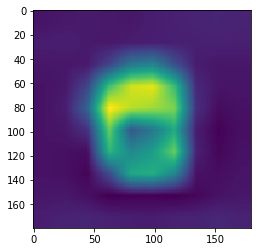

In [76]:
plt.imshow(regions.cpu().numpy()[0,0,:,:])